# New Sectcsion

In [1]:
!pip install pyspark


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, max, min, stddev
import random
import matplotlib.pyplot as plt
import pandas as pd
import os


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Set up storage paths in Google Drive
drive_path = "/content/drive/MyDrive/ResultManagement"
os.makedirs(drive_path, exist_ok=True)  # Ensure the directory exists

student_data_path = f"{drive_path}/student_data.csv"
output_stats_path = f"{drive_path}/output_results.csv"


In [5]:
spark = SparkSession.builder \
    .appName("ResultManagementSystem") \
    .config("spark.sql.shuffle.partitions", "4") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()


In [6]:
# Generate 10,000 students with marks
num_students = 10000
subjects = ["Electronics", "Programming", "Database", "DataScience", "Mathematics", "DSA"]

students = [
    (i, f"Student_{i}", random.randint(18, 25), *(random.randint(40, 100) for _ in subjects))
    for i in range(1, num_students + 1)
]

columns = ["StudentID", "Name", "Age"] + subjects

# Create Spark DataFrame
df = spark.createDataFrame(students, columns)


In [7]:
# Save DataFrame to Google Drive (acts like HDFS storage)
df.toPandas().to_csv(student_data_path, index=False)  # Save as CSV


In [8]:
# Read data back from Google Drive (simulating HDFS read)
if os.path.exists(student_data_path):  # Ensure the file exists before reading
    df_drive = spark.read.csv(student_data_path, header=True, inferSchema=True)
else:
    print("Error: Student data file not found!")
    spark.stop()
    exit()


In [9]:
# Compute statistics
stats = df_drive.agg(
    *[mean(col(s)).alias(f"Avg_{s}") for s in subjects],
    *[max(col(s)).alias(f"Max_{s}") for s in subjects],
    *[min(col(s)).alias(f"Min_{s}") for s in subjects],
    *[stddev(col(s)).alias(f"Std_{s}") for s in subjects]
)


In [10]:
# Save results to Google Drive
stats.toPandas().to_csv(output_stats_path, index=False)


In [11]:
# Convert to Pandas DataFrame
pdf = stats.toPandas().T
pdf.columns = ["Value"]


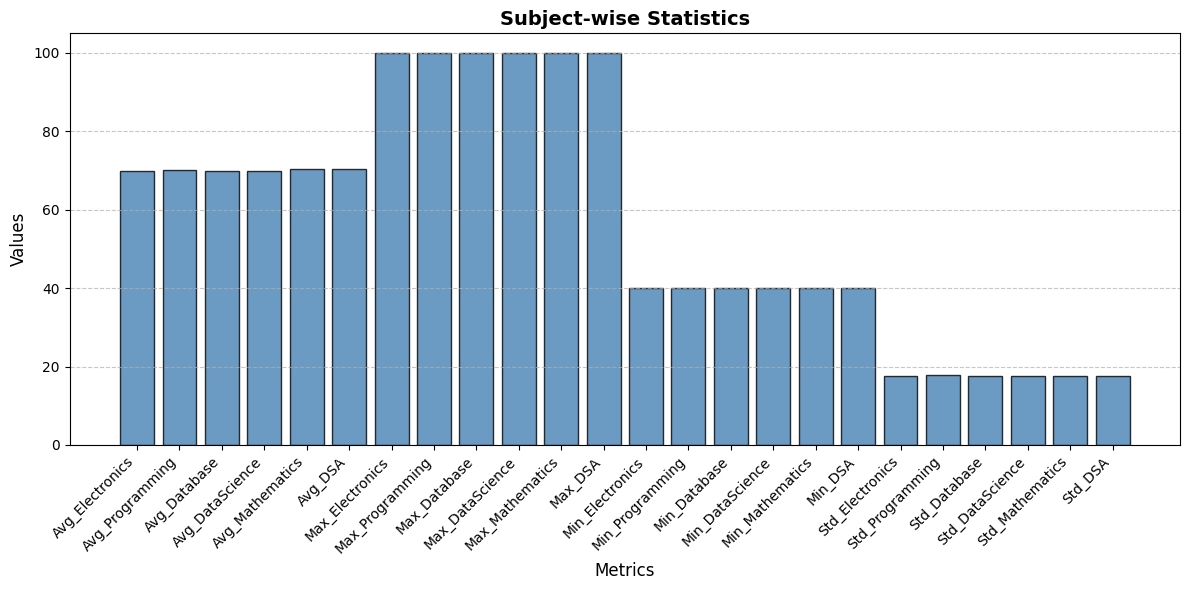

In [12]:
# Plot statistics
plt.figure(figsize=(12, 6))
plt.bar(pdf.index, pdf["Value"], color='steelblue', alpha=0.8, edgecolor='black')
plt.title("Subject-wise Statistics", fontsize=14, fontweight='bold')
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [13]:
# Stop Spark Session
spark.stop()
